# The Kaplan-Wald Confidence Bound for a Nonnegative Mean

This section presents an approach to finding lower confidence bounds for the mean of a nonnegative random variable described in H.M. Kaplan's (no longer online) website, http://printmacroj.com/martMean.htm. (An Internet Archive version is available at http://web.archive.org/web/20150220073515/http://printmacroj.com/martMean.htm.) That work fleshes out an idea due to Wald (1945, 2004), and is closely related to a technique presented in Kaplan (1987) based on martingale theory.

We start with a version for sampling with replacement, then develop finite-population (sampling without replacement) versions.

For another derivation of the IID version, see Stark & Teague (2014) https://www.usenix.org/system/files/jets/issues/0301/overview/jets_0301-stark.pdf


We have an iid sequence of random variables $X_1, X_2, \ldots$ such that $\mathbb P \{X_j \ge 0 \} = 1$. Let $F$ be their common distribution function. We seek a lower confidence bound for their common expectation $\mu \equiv \mathbb E X_1 = \int_0^\infty x dF$. 

Under the hypothesis that $\mu = t$, 

$$
   t^{-1} \mu =  t^{-1} \int_0^\infty  xdF(x) = \int_0^\infty xt^{-1} dF(x) = 1.
$$
Fix $\gamma \in [0, 1]$.
Because $\int_0^\infty dF = 1$, it follows that if $\mu  = t$,

$$  
    \mathbb E \left ( (\gamma/t) X_j + (1-\gamma) \right ) = (\gamma/t) \mathbb E X_j + (1-\gamma) =  
     (\gamma/t)t + (1-\gamma) = 1.
$$
Now,
$$
   \mathbb E \left ((\gamma/t) X_j + (1-\gamma) \right ) \equiv 
     \int_0^\infty \left (x \gamma/t + (1-\gamma) \right ) dF(x).
$$
Since for $x \ge 0$, $(x \gamma/t + (1-\gamma)) \ge 0$, it follows that if we define

$$
   dG \equiv (x \gamma/t + (1-\gamma))dF
$$

then $G$ is the cdf of a nonnegative random variable.

Let $Y$ be a random variable with cdf $G$.
By Jensen's inequality, $\mathbb E X_j^2 \ge (\mathbb E X_j)^2 = t \cdot \mathbb E X_j$ (by hypothesis).
Since $\mathbb E X_j = t \ge 0$,

\begin{align}
    \mathbb E Y  &= \int_0^\infty x dG(x) \\
                 &= \int_0^\infty x (x \gamma/t + (1-\gamma)) dF(x) \\
                 &= \gamma/t \int_0^\infty x^2 dF(x) + (1-\gamma) \int_0^\infty x dF(x) \\
                 &= \gamma/t \cdot \mathbb E X_j^2 + (1-\gamma) \cdot \mathbb E X_j \\
                 &\ge \gamma \cdot \mathbb E X_j + (1-\gamma) \cdot \mathbb E X_j  = \mathbb E X_j.
\end{align}
(The penultimate step uses Jensen's inequality.)

If the data allow us to reject the hypothesis $H_0$ that $\{ X_j\}$ are IID with cdf $F$
in favor of the alternative hypothesis $H_1$ that they are iid with cdf $G$,
we have strong statistical evidence that $\mu = \mathbb E X_j > t$.

## Using the SPRT to test $H_1$ versus $H_0$

Now a bit of magic occurs.  For a given observation $X_j = x_j$, what is the likelihood ratio of $H_1$ to $H_0$?

$$
    \mbox{LR} = \frac{dG(x_j)}{dF(x_j)} = \frac{(x_j\gamma/t+(1−\gamma))dF(x_j)}{dF(x_j)} = (x_j\gamma/t+(1−\gamma)).
$$
This doesn't depend on $F$ or $G$!

The $\mbox{LR}$ for observations $X_1, \ldots, X_m$ is
$$
      \mbox{LR} = \prod_{i=1}^m \left [ (\gamma/t) X_i + 1 - \gamma \right ].
$$
This expression shows why $\gamma$ was introduced in the first place:
for $\gamma = 1$, if even a single observation turned out to be zero, $\mbox{LR}$ would forever be
zero no matter how large subsequent observations turned out to be.
Taking $\gamma < 1$ hedges against that possibility.
Any value of $\gamma \in [0, 1]$ gives a conservative test, but smaller values provide more "protection"
against small values of $X_j$ (but incur a loss of power when all $X_j$ are large).

Recall that the $\mbox{LR}$ is the $P$-value of $H_0: \mu = t$ based on the observations $\{X_j\}_{j=1}^m$.
We will use this to find a lower confidence bound for $\mu$.

### "Lookahead" and the SPRT
There's more: recall that the SPRT says the chance that $\mbox{LR}$ _ever_ gets larger than $1/\alpha$ is at most $\alpha$ if $H_0$ is true.
That means that we can use the observations sequentially, maximizing over the partial products.
If any of the partial products exceeds $1/\alpha$, we can reject $H_0$.

That is, our level-$\alpha$ test based on a sample of size $n$ is
$$
    \mbox{ Reject } H_0 \mbox{ if } \max_{m=1}^n \prod_{i=1}^m \left [ \gamma X_i/t + 1 - \gamma \right ] \ge 1/\alpha.
$$

It is _only_ legitimate to do this maximization if the data are in random order.  For instance, it's impermissible to sort them from largest to smallest. And if you maximize over partial products, the result will, in general, depend on the order of the data.

## Confidence bounds from the Kaplan-Wald test

To find a lower confidence bound, we can invert hypothesis tests: the lower endpoint of a one-sided confidence bound for $\mu$ is the largest value 
of $t$ for which we would not reject the hypothesis $\mu = t$ at significance level $\alpha$.

For confidence levels above 50%, this lower confidence bound will certainly be between zero and the sample mean. However, for $t=0$, we have a divide-by-zero issue. Hence, for numerical implementation, we search the interval $[\epsilon, \bar{X}]$ for the smallest $t$ for which we can reject the hypothesis $\mu = t$ at significance level $\alpha$. If that smallest $t$ is $\epsilon$, we set the confidence bound to zero. 

The following code implements this idea, working with the log of the test statistic to improve numerical stability.

In [1]:
# This is the first cell with code: set up the Python environment
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pyplot as plt
import math

import numpy as np
from numpy.polynomial import polynomial as P

import scipy as sp
import scipy.stats
from scipy.stats import binom
from scipy.optimize import brentq

import pandas as pd

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import clear_output, display, HTML

In [2]:
def kaplanWaldLowerCI(x, cl = 0.95, gamma = 0.99, xtol=1.e-12, logf=True):
    '''
       Calculates the Kaplan-Wald lower 1-alpha confidence bound for the mean of a nonnegative random
       variable.
    '''
    alpha = 1.0-cl
    if any(x < 0):
        raise ValueError('Data x must be nonnegative.')
    elif all(x <= 0):
        lo = 0.0
    else:
        if logf:
            f = lambda t: (np.max(np.cumsum(np.log(gamma*x/t + 1 - gamma))) + np.log(alpha))
        else:
            f = lambda t: (np.max(np.cumprod(gamma*x/t + 1 - gamma)) - 1/alpha)
        xm = np.mean(x)
        if f(xtol)*f(xm) > 0.0:
            lo = 0.0
        else:
            lo = sp.optimize.brentq(f, xtol, np.mean(x), xtol=xtol) 
    return lo

## How well does it work?
Let's test the method on our standard test problems: binomial and a mixture of pointmass and uniform.  We will fix $\gamma$; you might experiment using different values.

In [3]:
# Nonstandard mixture: a pointmass at 1 and a uniform[0,1]
ns = np.array([25, 50, 100, 400])  # sample sizes
ps = np.array([0.9, 0.99, 0.999])    # mixture fraction, weight of pointmass
alpha = 0.05  # 1- (confidence level)
reps = int(10**4)   # just for demonstration
gamma = 0.99
xtol = 1.e-12

simTable = pd.DataFrame(columns=('mass at 1', 'sample size', 'Student-t cov',\
                                 'Kaplan-Wald cov', 'Student-t low', 'Kaplan-Wald low')
                       )

for p in ps:
    popMean = (1-p)*0.5 + p  # population is a mixture of uniform with mass (1-p) and
                             # pointmass at 1 with mass p
    
    for n in ns:
        tCrit = sp.stats.t.ppf(q=1-alpha, df=n-1)
        coverT = 0
        coverK = 0
        lowT = 0.0
        lowK = 0.0
        
        for rep in range(int(reps)):
            sam = np.random.uniform(size=n)  # the uniform part of the sample
            ptMass = np.random.uniform(size=n)  # for a bunch of p-coin tosses
            sam[ptMass < p] = 1.0   # mix in pointmass at 1, with probability p
            # t interval
            samMean = np.mean(sam)
            samSD = np.std(sam, ddof=1)
            tLo = samMean - tCrit*samSD  # lower endpoint of the t interval
            coverT += ( tLo <= popMean )
            lowT += tLo
            #  Kaplan-Wald interval
            kLo = kaplanWaldLowerCI(sam, cl=1-alpha, gamma=gamma, xtol=xtol) # lower endpoint of the Kaplan-Wald interval
            coverK += (kLo <= popMean )
            lowK += kLo

        simTable.loc[len(simTable)] =  p, n,\
            str(100*float(coverT)/float(reps)) + '%',\
            str(100*float(coverK)/float(reps)) + '%',\
            str(round(lowT/float(reps),4)),\
            str(round(lowK/float(reps),4))
#
ansStr =  '<h3>Simulated coverage probability and expected lower endpoint of ' +\
          'one-sided Student-t and Kaplan-Wald confidence intervals for ' +\
          'mixture of U[0,1] and pointmass at 1 population</h3>' +\
          '<strong>Nominal coverage probability ' + str(100*(1-alpha)) +\
          '%</strong>. Gamma=' + str(gamma) +\
          '.<br /><strong>Estimated from ' + str(int(reps)) +\
          ' replications.</strong>'

display(HTML(ansStr))
display(simTable)

,mass at 1,sample size,Student-t cov,Kaplan-Wald cov,Student-t low,Kaplan-Wald low
0,0.900,25,90.14%,100.0%,0.6822,0.8199
1,0.900,50,98.55%,100.0%,0.6702,0.8711
2,0.900,100,99.93%,97.34%,0.6645,0.8952
3,0.900,400,100.0%,96.92%,0.6621,0.8954
4,0.990,25,22.14%,100.0%,0.9538,0.8792
5,0.990,50,39.22%,100.0%,0.9411,0.9338
6,0.990,100,61.73%,100.0%,0.9281,0.9628
7,0.990,400,97.86%,100.0%,0.9066,0.9847
8,0.999,25,2.34%,100.0%,0.9955,0.8855
9,0.999,50,4.77%,100.0%,0.994,0.9407


Looks pretty good!  Next we will introduce one more method, then we'll compare the various methods we've seen.

## Upper confidence bounds and two-sided bounds

If every $X_j$ has the same finite, a priori upper bound $u$, we can transform the problem by defining $\tilde{X_j}= u - X_j$.  Then $\tilde{X_j}$ is a nonnegative random variable, and a lower confidence bound on its mean translated to can be subtracted from $u$ to make an upper confidence bound on $\mathbb E X_j$.

If every $X_j$ has the finite, a priori upper and lower bound, we can find two-sided confidence intervals in the analogous way, applying the Kaplan Wald method to the original data to find lower confidence bounds and to the data subtracted from the a priori upper bound to find upper confidence bounds.

## Lower confidence bounds on the mean for sampling without replacement: Kolmogorov's inequality

This is an alternative derivation of the Kaplan-Wald method, also from [Harold Kaplan's website](http://web.archive.org/web/20131209044835/http://printmacroj.com/martMean.htm), involving
the martingale property of a suitably constructed sequence.
It relies on Kolmogorov's inequality for optionally stopped closed martingales.

Suppose we are sampling without replacement from a finite population of $N$ 
non-negative items,  $\{x_1, \ldots, x_N\}$, with $x_j \ge 0$ $\forall j$.
The population mean is $\mu = \frac{1}{N} \sum_{j=1}^N x_j \ge 0$ and the population total
is $N\mu \ge 0$.
We draw $\{X_1, \ldots, X_n \}$ sequentially without replacement.
On the hypothesis $\mu = t$, $\mathbb{E}X_1 = t$, so $\mathbb{E}(X_1/t) = 1$.
Conditional on $X_1, \ldots, X_n$, the total of the remaining $N-n$ items is
$N\mu - \sum_{j=1}^n X_j$, so the mean of the remaining items is

$$
    \frac{Nt-\sum_{j=1}^n X_j}{N-n} = \frac{t - \frac{1}{N} \sum_{j=1}^n X_j}{1-n/N}.
$$
Thus, the expected value of $X_{n+1}$ given $X_1, \ldots, X_n$ is 
$\frac{t - \frac{1}{N} \sum_{j=1}^n X_j}{1-n/N}$.

Define 

$$
Y_1(t) \equiv
\begin{cases}
X_1/t,& Nt > 0, \\
1,&   Nt = 0, \\
\end{cases}
$$

and for $1 \le n \le N-1$,
$$
Y_{n+1}(t) 
\equiv
\begin{cases}
X_{n+1} 
\frac
{1 - \frac{n}{N}}
{t - \frac{1}{N} \sum_{j=1}^n X_j},& \sum_{j=1}^n X_j < Nt, \\
1,& \sum_{j=1}^n X_j \ge Nt. \\
\end{cases}
$$ 

Then $\mathbb{E}(Y_{n+1}(t) | Y_1, \ldots Y_n) = 1$.
Let $Z_{n}(t) \equiv \prod_{j=1}^n Y_j(t)$.
Note that $Y_k(t)$ can be recovered from $\{Z_j(t), j \le k\}$, 
since $Y_k(t) = Z_k(t)/Z_{k-1}(t)$.
Now $\mathbb{E}|Z_k| \le \max_j x_j < \infty$ and

$$
   \mathbb{E}\left ( Z_{n+1}(t) | Z_1(t), \ldots Z_n(t) \right ) = 
   \mathbb{E} \left (Y_{n+1}(t)Z_n(t) | Z_1(t), \ldots Z_n(t) \right ) = Z_n(t).
$$

Thus 

$$
    \left ( Z_1(t), Z_2(t), \;\ldots , Z_N(t) \right )
$$

is a non-negative closed martingale.

By Kolmogorov's inequality, an application of Markov's inequality to martingales
(Feller V2, p.242), for any $p > 0$ and any $J \in \{1, \ldots, N \}$,

$$
     \Pr \left ( \max_{1 \le j \le J} Z_j(t) > 1/p \right ) \le p \; \mathbb{E}|Z_J|.
$$

Since $(Z_j)$ is a non-negative martingale, $\mathbb{E}|Z_J| = \mathbb{E}Z_J = \mathbb{E}Z_1 = 1$.

Thus a $p$-value for the hypothesis $\mu = t$ based on data $X_1, \ldots X_J$ is 
$\left (\max_{1 \le j \le J} Z_j(t) \right )^{-1} \wedge 1$.
If $X_j = 0$ for some $j$, then $Z_k = 0$ for all $k \ge j$.

To avoid that problem, we can shift everything to the right: pick $\gamma > 0$,
find a lower confidence bound for $\delta = \mu+\gamma > \mu > 0$ from data $\{X_j+\gamma\}$, then subtract $\gamma$ from the lower 
confidence bound to get a lower confidence bound for $\mu$.
There are tradeoffs involved in picking $\gamma$: if many $X_j$ turn out to be 
small, especially for small $j$, it helps to have $\gamma$ large, and vice versa.

Unpacking the math yields the $p$ value

$$
p_{\mathrm{KK}} \equiv 1 \wedge \left ( \max_{1 \le j \le J} \prod_{k=1}^j (X_{k}+\gamma) \frac{1-(k-1)/N}{t - \frac{1}{N} \sum_{\ell=1}^{k-1} (X_\ell+\gamma)} \right )^{-1}
$$
for the hypothesis that $\mu \le t - \gamma$.

The corresponding $1-\alpha$ lower confidence bound is

$$
   \sup \left \{t \ge 0: \max_{1 \le j \le J}  \prod_{k=1}^j (X_{k}+\gamma) \frac{1-(k-1)/N}{t - \frac{1}{N} \sum_{\ell=1}^{k-1} (X_\ell+\gamma)} \le 1/\alpha \right \} - \gamma.
$$

### Application: marbles in a jar

A certain jar contains $N$ (even) marbles, $G$ green and $N-G$ non-green.
We sample marbles sequentially without replacement. We wish to test the hypothesis
$G \le N/2$ against the alternative.
For instance, $G$ might represent the number of votes for the reported winner of an election
in which $N$ votes were cast.
If the social choice function requires a majority, or if there are only two candidates, then
green wins if $G > N/2$ and the outcome is a tie or a loss if $G \le N/2$.
If we can reject the hypothesis that $G \le N/2$, we can conclude that the outcome is correct.

Use the previous method, taking $t = 1/2$ and shift $\delta > 0$.
A pleasing choice for symmetry would be $\delta = 1/2$, but the operating characteristics
depend on the true value of $G$.

## Another martingale test for the mean for sampling without replacement

Let's define a finite-sample version of the Kaplan-Wald approach, to which we can apply Kolmogorov's Inequality.

Let $S_j \equiv \sum_{k=1}^j X_k$, $\tilde{S}_j \equiv S_j/N$, and $\tilde{j} \equiv 1 - (j-1)/N$.
Define

$$
   Y_n \equiv \int_0^1 \prod_{j=1}^n \left ( \gamma \left [ X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1 \right ] + 1 \right ) d\gamma.
$$

This is a polynomial in $\gamma$ of degree at most $n$, with constant term $1$.
Each $X_j$ appears linearly.
Under the null hypothesis that the population total is $Nt$, $\mathbb{E} X_1 = t$,
and 

$$
  \mathbb{E} \left ( X_j \mid X_1, \ldots, X_{j-1} \right ) = 
  \frac{Nt - S_{j-1}}{N-j+1} = \frac{t - \tilde{S}_{j-1}}{\tilde{j}}.
$$

Now 

$$
   Y_1 = \int_0^1 \left ( \gamma [ X_1/t - 1] + 1 \right ) d\gamma = 
   \left [ (\gamma^2/2) [X_1/t - 1] + \gamma \right ]_{\gamma=0}^1 = [X_1/t - 1]/2 + 1 = \frac{X_1}{2t} + 1/2.
$$

Thus, under the null, 
$$
   \mathbb{E}Y_1 = \frac{\mathbb{E}X_1}{2t} + 1/2 = 1.
$$

Also,

$$
   \mathbb{E}(Y_n | X_1, \ldots, X_{n-1}) =
   \mathbb{E} \left . \left [ \int_0^1 \prod_{j=1}^n \left (\gamma \left [ X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1 \right ] + 1 \right ) d\gamma \right | X_1, \ldots, X_{n-1} \right ]
$$
$$
  = \int_0^1  \left (\gamma \left [ \mathbb{E}(X_n | X_1, \ldots, X_{n-1}) \frac{\tilde{n}}{t - \tilde{S}_{n-1}} -1 \right ] + 1 \right ) \prod_{j=1}^{n-1} \left ( \gamma \left [ X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1 \right ] + 1 \right ) d\gamma 
$$
$$
  = \int_0^1  \left (\gamma \left [ \frac{t - \tilde{S}_{n-1}}{\tilde{n}} \frac{\tilde{n}}{t - \tilde{S}_{n-1}} -1 \right ] + 1 \right ) \prod_{j=1}^{n-1} \left ( \gamma \left [ X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1 \right ] + 1 \right ) d\gamma 
$$
$$
  = \int_0^1  \prod_{j=1}^{n-1} \left ( \gamma \left [ X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1 \right ] + 1 \right ) d\gamma = Y_{n-1}.
$$

Thus, under the null hypothesis, $(Y_j )_{j=1}^N$ is a nonnegative closed martingale with expected value 1, and Kolmogorov's inequality implies that for any $J \in \{1, \ldots, N\}$,

$$
   \Pr \left ( \max_{1 \le j \le J} Y_j(t) > 1/p \right ) \le p.
$$

Set 

$$
    c_j \equiv X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1,
$$

and re-write the polynomial

$$
 \prod_{j=1}^n \left (\gamma \left [ X_j \frac{\tilde{j}}{t - \tilde{S}_{j-1}} -1 \right ] + 1 \right ) = \prod_{j: c_j \ne 0} c_j(\gamma + c_j^{-1}).
$$
This expresses the polynomial in terms of its roots, facilitating computations in Python.
Using this notation,

$$
   Y_j = \int_0^1 \prod_{j: c_j \ne 0} c_j(\gamma + c_j^{-1}) d\gamma =
   \left ( \prod_{j: c_j \ne 0} c_j \right ) \int_0^1 \prod_{j: c_j \ne 0} (\gamma + c_j^{-1}) d\gamma.
$$

In [4]:
def KK_p(x, N, t, random_order = True):
    '''
    p-value for the hypothesis that the mean of a nonnegative population with N
    elements is t. The alternative is that the mean is larger than t.
    If the random sample x is in the order in which the sample was drawn, it is
    legitimate to set random_order = True. 
    If not, set random_order = False. 
    '''
    x = np.array(x)
    assert all(x >=0),  'Negative value in a nonnegative population!'
    assert len(x) <= N, 'Sample size is larger than the population!'
    assert N > 0,       'Population size not positive!'
    assert N == int(N), 'Non-integer population size!'
    sample_total = 0.0
    mart = x[0]/t if t > 0 else 1
    mart_max = mart
    for j in range(1, len(x)):
        mart *= x[j]*(1-j/N)/(t - (1/N)*sample_total)
        if mart < 0:
            mart = np.inf
            break
        else:
            sample_total += x[j]
        mart_max = max(mart, mart_max)
    p = min((1/mart_max if random_order else 1/mart),1)
    return p   

def HK_ps_p(x, N, t, random_order = True):
    '''
    Harold Kaplan p-value for the hypothesis that the mean of a nonnegative 
    population with N elements is t. 
    The alternative is that the mean is larger than t.
    If the random sample x is in the order in which the sample was drawn, it is
    legitimate to set random_order = True. 
    If not, set random_order = False. 
    '''
    x = np.array(x)
    assert all(x >=0),  'Negative value in a nonnegative population!'
    assert len(x) <= N, 'Sample size is larger than the population!'
    assert N > 0,       'Population size not positive!'
    assert N == int(N), 'Non-integer population size!'
    Stilde = (np.insert(np.cumsum(x),0,0)/N)[0:len(x)] # \tilde{S}_{j-1}
    t_minus_Stilde = t - Stilde
    mart_max = 1
    if any(t_minus_Stilde < 0): # sample total exceeds hypothesized population total
        mart_max = np.inf
    else:  # TO FIX: need to deal with zeros in t_minus_stilde
        jtilde = 1 - np.array(list(range(len(x))))/N
        # c_j = X_j*\tilde{j}/(t-\tilde{S}_{j-1}) - 1
        c = np.multiply(x, np.divide(jtilde, t_minus_Stilde))-1  # need to test for zeros!
        for j in range(len(x)):
            r = -np.array([1/cc for cc in c[0:j+1] if cc != 0]) # roots
            if r.size > 0:
                Y_norm = np.prod(np.array([cc for cc in c[0:j+1] if cc != 0])) # multiplicative constant
                poly = P.polyfromroots(r)
                poly_int = P.polyint(poly)
                poly_int_values = P.polyval([1], poly_int)
                mart = Y_norm*poly_int_values[0]
                mart_max = max(mart_max, mart) if random_order else mart
            else:
                mart_max = max(mart_max, 1) if random_order else 1
    p = min(1/mart_max,1)
    return p   

In [5]:
## Harold Kaplan's javascript routine asStated() translated into python

def HK_p(x, N, t, random_order = True):
    x = np.array(x)
    assert all(x >=0),  'Negative value in a nonnegative population!'
    assert len(x) <= N, 'Sample size is larger than the population!'
    assert N > 0,       'Population size not positive!'
    assert N == int(N), 'Non-integer population size!'
    big = 0.
    denominator = 1
    sumOfPreviousXValues = 0.
    n = len(x)
    w = np.zeros(n+1)
    w[0] = 1
    for j in range(1,n+1):
        reduced_t = t - sumOfPreviousXValues/N
        if reduced_t < 0:
            return 0
        expectedX = reduced_t/( 1-(j-1)/N )
        if expectedX > 0:
            quotient = x[j-1]/expectedX
            for k in range(j,0,-1):
                w[k] = quotient*w[k-1]*k/j + w[k]*(j-k)/j
            denominator += 1
        tot = np.sum(w[0:(j+1)])
        candidate = tot/denominator
        big = max(big, candidate) if random_order else candidate
        sumOfPreviousXValues += x[j-1]
        reduced_t = t - sumOfPreviousXValues/N
        if reduced_t < 0:
            return 0
    return min(1/big,1)

In [6]:
# Compare the python implementation with the translation of Kaplan's javascript into python
x = np.array(range(10)) 
t = 1
N = 1000
print(HK_p(x, N, t), HK_ps_p(x, N, t))

0.00013854893672071193 0.00013854893672071193


In [7]:
# term-by-term integration of the polynomial is unstable when the sample size is large:

N =200000
x = np.array([0]*50 + [1000]*40)
t = 300
print('Kaplan:', HK_p(x, N, t), ' term-by-term:', HK_ps_p(x, N, t))

Kaplan: 0.08356599335793194  term-by-term: 6.901117780518795e-07


In [8]:
def CI_from_test(x, N, cl=0.95, d = 0, random_order = True,
                         p_value = HK_p, **kwargs):
    '''
    Lower confidence bound for the mean of a finite, nonnegative population.
    
    x: data, a random sample without replacement
    N: population size
    cl: desired confidence level
    d: a shift. If d!=0, finds a confidence interval for the mean of x+d, then subtracts d.
       d must be selected before looking at the data
    random_order: if True, the data x must be in the (random) order in which the sample was
        drawn. If x is not known to be in random order, set random_order = False
    '''
    
    assert cl > 0.5,    'Confidence level must be at least 50%.'
    assert all(x >=0),  'Negative value in a nonnegative population!'
    assert len(x) <= N, 'Sample size is larger than the population!'
    assert N > 0,       'Population size not positive!'
    assert N == int(N), 'Non-integer population size!'
    
    x = np.array(x)
    
    # a lower confidence bound at cl > 0.5 should not be larger than the sample mean
    if random_order:
        u = np.amax(np.array([np.mean(x[0:j+1]) for j in range(len(x))]))
    else:
        u = np.mean(x) 
    f = lambda t: p_value(x+d, N, t, random_order = random_order) - (1-cl)
    lcl = 0.0
    if f(0) < 0.0:
        lcl = brentq(f, 0, u+d, *kwargs) - d
    return max(lcl,0)

In [9]:
cl = 1-.05

N = 200000
x = [0]*250 + [100]*250 
x = np.array(x)
reps = int(10)

sims_kk = np.zeros(reps)
sims = np.zeros(reps)
for i in range(reps):
    xp = np.random.permutation(x)
    sims[i] = CI_from_test(x, N, d=0, cl=cl, random_order = True, 
                                  p_value = HK_p)
    sims_kk[i] = CI_from_test(x, N, d=10, cl=cl, random_order = True, 
                                  p_value = KK_p)
print(np.mean(sims), np.mean(sims_kk))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


42.72591163814959 22.97057467741891


In [10]:
n = 10
reps = 10**4
p = np.zeros(reps)
for i in range(int(reps)):
    p[i] = HK_p(2*np.random.random(n), N, 1)

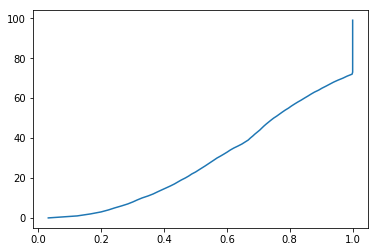

In [11]:
pct = np.percentile(p, range(100))
plt.plot(pct, range(100))

In [ ]:
# Nonstandard mixture: a pointmass at 1 and a uniform[0,1]
ns = np.array([25, 50, 100, 400])  # sample sizes
ps = np.array([0.9, 0.99, 0.999])    # mixture fraction, weight of pointmass
alpha = 0.05  # 1- (confidence level)
reps = int(10**2)   # just for demonstration
d = 1
xtol = 1.e-12
N = 20000 # hypothetical population size

simTable = pd.DataFrame(columns=('mass at 1', 'sample size', 'Kaplan-Kolmogorov cov',\
                                 'Kaplan-Wald cov', 'KK low', 'Kaplan-Wald low')
                       )

for p in ps:
    popMean = (1-p)*0.5 + p  # population is a mixture of uniform with mass (1-p) and
                             # pointmass at 1 with mass p
    
    for n in ns:
        tCrit = sp.stats.t.ppf(q=1-alpha, df=n-1)
        coverT = 0
        coverK = 0
        lowT = 0.0
        lowK = 0.0
        
        for rep in range(int(reps)):
            sam = np.random.uniform(size=n)  # the uniform part of the sample
            ptMass = np.random.uniform(size=n)  # for a bunch of p-coin tosses
            sam[ptMass < p] = 1.0   # mix in pointmass at 1, with probability p
            # Kaplan's mixture
            tLo = CI_from_test(sam, N, d=0, cl=cl, random_order = True, 
                                  p_value = HK_p)
            coverT += ( tLo <= popMean )
            lowT += tLo
            #  Kaplan-Wald interval
            kLo = CI_from_test(sam, N, d=d, cl=cl, random_order = True, 
                                  p_value = KK_p) # lower endpoint of the Kaplan-Wald interval
            coverK += (kLo <= popMean )
            lowK += kLo

        simTable.loc[len(simTable)] =  p, n,\
            str(100*float(coverT)/float(reps)) + '%',\
            str(100*float(coverK)/float(reps)) + '%',\
            str(round(lowT/float(reps),4)),\
            str(round(lowK/float(reps),4))
#
ansStr =  '<h3>Simulated coverage probability and expected lower endpoint of ' +\
          'one-sided Kaplan-Kolmogorov and Kaplan-Wald confidence intervals for ' +\
          'mixture of U[0,1] and pointmass at 1 population of' + str(N) + 'items</h3>' +\
          '<strong>Nominal coverage probability ' + str(100*(1-alpha)) +\
          '%</strong>. d=' + str(d) +\
          '.<br /><strong>Estimated from ' + str(int(reps)) +\
          ' replications.</strong>'

display(HTML(ansStr))
display(simTable)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


In [ ]:
# Nonstandard mixture: a pointmass at 0 and a uniform[0,1]
ns = np.array([25, 50, 100, 400])  # sample sizes
ps = np.array([0.9, 0.99, 0.999])    # mixture fraction, weight of pointmass
alpha = 0.05  # 1- (confidence level)
reps = int(10**2)   # just for demonstration
d = 1
xtol = 1.e-12
N = 20000 # hypothetical population size

simTable = pd.DataFrame(columns=('mass at 0', 'sample size', 'Kaplan-Kolmogorov cov',\
                                 'Kaplan-Wald cov', 'KK low', 'KW low')
                       )

for p in ps:
    popMean = (1-p)*0.5 + p*0  # population is a mixture of uniform with mass (1-p) and
                               # pointmass at 0 with mass p
    
    for n in ns:
        tCrit = sp.stats.t.ppf(q=1-alpha, df=n-1)
        coverT = 0
        coverK = 0
        lowT = 0.0
        lowK = 0.0
        
        for rep in range(int(reps)):
            sam = np.random.uniform(size=n)  # the uniform part of the sample
            ptMass = np.random.uniform(size=n)  # for a bunch of p-coin tosses
            sam[ptMass < p] = 0.0   # mix in pointmass at 0, with probability p
            # Kaplan's mixture
            tLo = CI_from_test(sam, N, d=0, cl=cl, random_order = True, 
                                  p_value = HK_p)
            coverT += ( tLo <= popMean )
            lowT += tLo
            #  Kaplan-Wald interval
            kLo = CI_from_test(sam, N, d=d, cl=cl, random_order = True, 
                                  p_value = KK_p) # lower endpoint of the Kaplan-Wald interval
            coverK += (kLo <= popMean )
            lowK += kLo

        simTable.loc[len(simTable)] =  p, n,\
            str(100*float(coverT)/float(reps)) + '%',\
            str(100*float(coverK)/float(reps)) + '%',\
            str(round(lowT/float(reps),4)),\
            str(round(lowK/float(reps),4))
#
ansStr =  '<h3>Simulated coverage probability and expected lower endpoint of ' +\
          'one-sided Kaplan-Kolmogorov and Kaplan-Wald confidence intervals for ' +\
          'mixture of U[0,1] and pointmass at 0 population of' + str(N) + 'items</h3>' +\
          '<strong>Nominal coverage probability ' + str(100*(1-alpha)) +\
          '%</strong>. d=' + str(d) +\
          '.<br /><strong>Estimated from ' + str(int(reps)) +\
          ' replications.</strong>'

display(HTML(ansStr))
display(simTable)

## What's next?

+ [Next: Dollar-unit sampling and taint](dus.ipynb)
+ [Previous: Wald's Sequential Probability Ratio Test](sprt.ipynb)
+ [Index](index.ipynb)